In [1]:
import torch
import torchvision
import os
import PIL.Image

device = 'cuda'
dtype = torch.float16

compose = {
    'input':
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=767, max_size=768),
    ]),
    'to_tensor':
    torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5])
    ]),
    'to_tensor_encoder':
    torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ])
}

from diffusers import DDPMScheduler

scheduler_noise = DDPMScheduler(beta_end=0.012,
                                beta_schedule='scaled_linear',
                                beta_start=0.00085,
                                clip_sample=False,
                                steps_offset=1)
scheduler_noise.set_timesteps(50)

compose, scheduler_noise

({'input': Compose(
      Resize(size=767, interpolation=bilinear, max_size=768, antialias=None)
  ),
  'to_tensor': Compose(
      ToTensor()
      Normalize(mean=[0.5], std=[0.5])
  ),
  'to_tensor_encoder': Compose(
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )},
 DDPMScheduler {
   "_class_name": "DDPMScheduler",
   "_diffusers_version": "0.30.1",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.00085,
   "clip_sample": false,
   "clip_sample_range": 1.0,
   "dynamic_thresholding_ratio": 0.995,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "rescale_betas_zero_snr": false,
   "sample_max_value": 1.0,
   "steps_offset": 1,
   "thresholding": false,
   "timestep_spacing": "leading",
   "trained_betas": null,
   "variance_type": "fixed_small"
 })

In [2]:
from accelerate import Accelerator
%run 1.vae.ipynb
%run 2.unet.ipynb
%run 3.encoder.ipynb
%run 4.controlnet.ipynb

#controlnet.load_state_dict(torch.load('model/controlnet_1730709235'))

vae.requires_grad_(False).to(device, dtype)
unet.requires_grad_(False).to(device, dtype)
encoder.requires_grad_(False).to(device, dtype)
controlnet.eval()

accelerator = Accelerator(mixed_precision='fp16')

controlnet = accelerator.prepare(controlnet)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [3]:
@torch.no_grad()
def predict(image_small, image_original):
    q, _ = vae.encode(image_small)
    q = torch.randn_like(q)

    kv = encoder(image_original).to(device, dtype)

    for timestep in scheduler_noise.timesteps:
        controlnet_down, controlnet_mid = controlnet(
            q=q, kv=kv, timestep=timestep, controlnet_cond=image_small)

        controlnet_mid = controlnet_mid.to(device, dtype)
        controlnet_down = [i.to(device, dtype) for i in controlnet_down]

        pred_noise = unet(q=q,
                          kv=kv,
                          timestep=timestep,
                          controlnet_down=controlnet_down,
                          controlnet_mid=controlnet_mid)

        q = scheduler_noise.step(pred_noise, timestep, q, return_dict=False)[0]

    return vae.decode(q / 0.18215)


predict(
    torch.randn(1, 3, 100, 100).to(device, dtype),
    torch.randn(1, 3, 100, 100).to(device, dtype)).shape

torch.Size([1, 3, 96, 96])

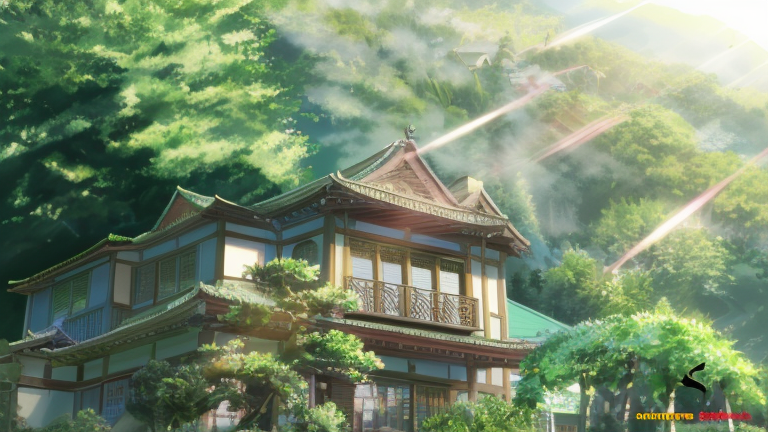

In [4]:
def predict_image(image):
    image = compose['input'](image)
    image_small = compose['to_tensor'](image).unsqueeze(0).to(device, dtype)
    image_original = compose['to_tensor_encoder'](image).unsqueeze(0).to(
        device, dtype)

    image_predict = predict(image_small, image_original)

    image_predict = image_predict.detach().cpu().float()
    image_predict = image_predict[0].permute(1, 2, 0).numpy()
    image_predict = image_predict * 0.5 + 0.5
    image_predict = (image_predict * 255).clip(0, 255).astype('uint8')

    return PIL.Image.fromarray(image_predict)


predict_image(PIL.Image.open('dataset/image_test/1700.jpg').convert('RGB'))

uwp3920590.jpeg


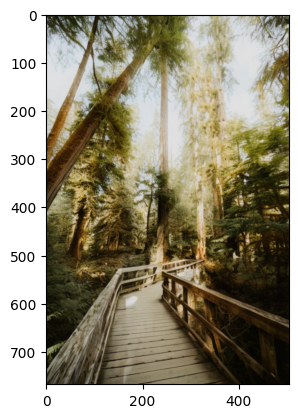

1700.jpg


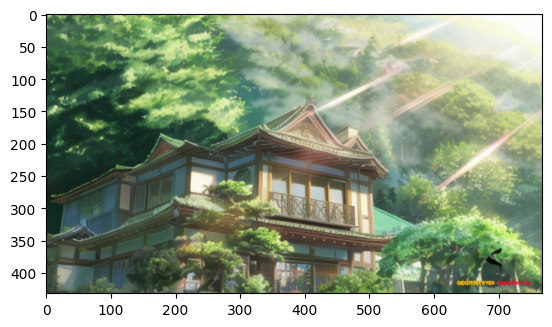

wp3214362.jpg


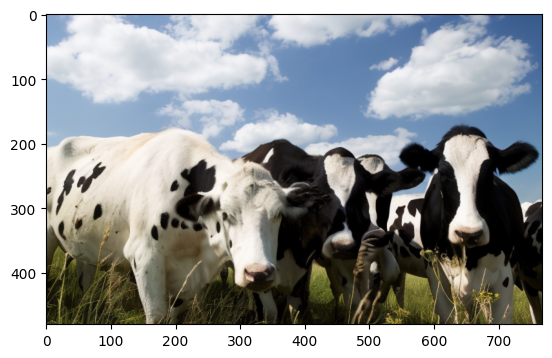

wp14387850.jpg


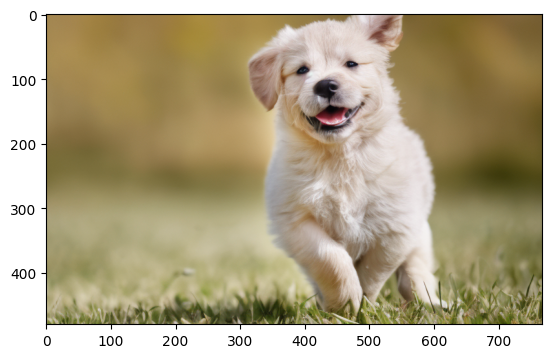

uwp4240546.jpeg


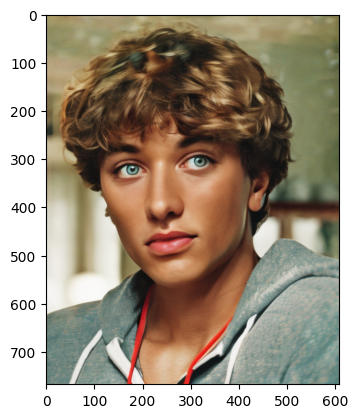

3000.jpg


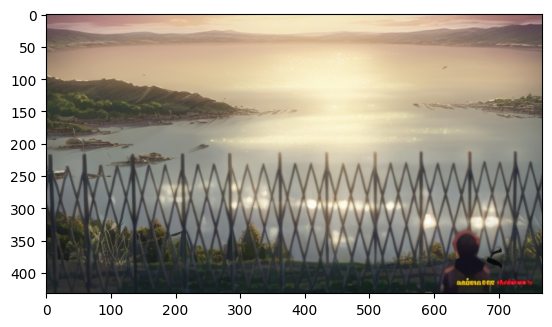

uwp4486894.jpeg


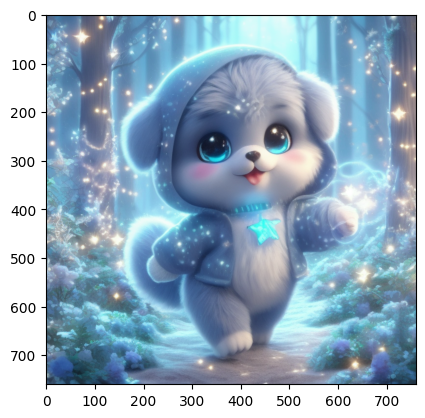

wp6652139.jpg


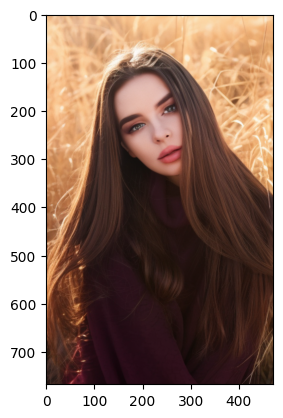

4500.jpg


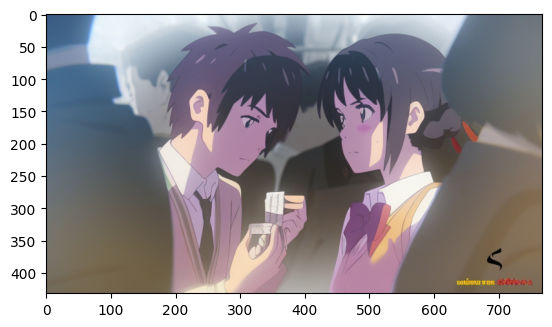

2200.jpg


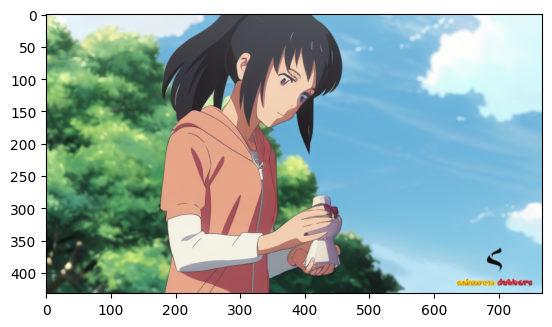

1500.jpg


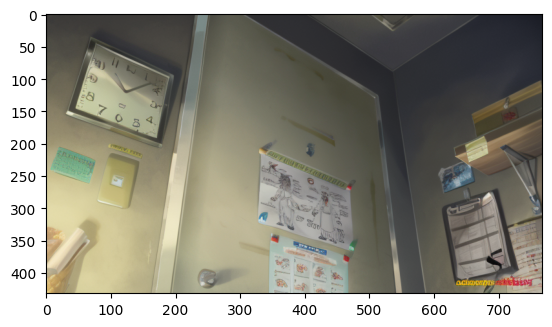

In [5]:
from matplotlib import pyplot as plt

root = 'dataset/image_test'
for filename in os.listdir(root):
    try:
        image = PIL.Image.open(os.path.join(root, filename)).convert('RGB')
    except:
        continue

    print(filename)

    image = image.resize([i // 4 for i in image.size])

    path = os.path.join(root, 'original', filename)
    image.save(path)
    image = PIL.Image.open(path)

    image = image.resize([i * 4 for i in image.size])

    image = predict_image(image)
    path = os.path.join(root, 'predict', filename)
    image.save(path)
    plt.imshow(image)
    plt.show()